In [1]:
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Optional, TypeAlias
import pandas as pd
import numpy as np

from strategy_portfolio_opt.constrained_min import ConstrainedMin

In [2]:
tickers = {
    "tech": ["AAPL", "MSFT", "TSLA"],
    "healthcare": ["JNJ", "PFE", "MRK"],
    "financials": ["JPM", "BAC", "WFC"],
    "energy": ["XOM", "CVX", "SLB"],
    "consumer": ["PG", "KO", "WMT"],
    "commodities": ["GC=F", "CL=F"]
}

TEST_CUTOFF = pd.Timestamp("2023-01-01", tz="UTC")

In [ ]:
for sector, symbols in tickers.items():
    print(f"Fetching data for {sector} sector...")
    for symbol in symbols:
        try:
            ticker_data = yf.Ticker(symbol)
            hist = ticker_data.history(start="2010-01-01")
            
            mask_test = hist.index >= TEST_CUTOFF
            df_test = hist.loc[mask_test].copy()
            df_train = hist.loc[~mask_test].copy()

            train_path = f"historical_data/{symbol}_train.csv"
            test_path  = f"historical_data/{symbol}_test.csv"
            
            df_train.to_csv(train_path)
            df_test.to_csv(test_path)
            print(f"Split '{symbol}' →")
            print(f"    TRAIN ({len(df_train)} rows) → {train_path}")
            print(f"    TEST  ({len(df_test)} rows) → {test_path}")

            print(f"{symbol} data fetched successfully.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    print(f"Finished fetching data for {sector} sector.\n")

In [3]:
def moving_average_crossover(df: pd.DataFrame,
                             short_window: int = 30,
                             long_window: int = 178) -> pd.DataFrame:
    """
    Compute a simple moving‐average crossover strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    short_window : int
        Window size for the short SMA (e.g., 20 days).
    long_window : int
        Window size for the long SMA (e.g., 50 days).

    Returns
    -------
    pd.DataFrame
        Original DataFrame with the following added columns:
          - 'SMA_short' : short‐period moving average
          - 'SMA_long'  : long‐period moving average
          - 'Signal'    : 1 when short crosses above long,
                          -1 when short crosses below long, else 0
    """

    df = df.copy()

    # Ensure 'Date' is a datetime type and set as index if not already
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute Simple Moving Averages
    df["SMA_short"] = df["Close"].rolling(window=short_window, min_periods=1).mean()
    df["SMA_long"]  = df["Close"].rolling(window=long_window, min_periods=1).mean()

    # 2) Generate raw crossover signals: 
    #    - When SMA_short > SMA_long → 1 (long), when SMA_short < SMA_long → 0
    df["Crossover"] = np.where(df["SMA_short"] > df["SMA_long"], 1, 0)

    # 3) The actual “Signal” is the change in Crossover:
    #    - A rising edge (0→1) means a buy signal (1)
    #    - A falling edge (1→0) means a sell signal (−1)
    df["Signal"] = df["Crossover"].diff().fillna(0)
    df["Signal"] = df["Signal"].map({1.0: 1, -1.0: -1}).fillna(0).astype(int)

    # Rows where no crossover event happen remain at 0
    # Cleanup temporary column if you don’t need it:
    df.drop(columns=["Crossover"], inplace=True)

    return df

In [4]:
def bollinger_bands_strategy(df: pd.DataFrame,
                             window: int = 49,
                             num_std: float = 3.0) -> pd.DataFrame:
    """
    Compute a simple Bollinger Bands breakout strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    window : int
        Rolling window size for moving average and standard deviation.
    num_std : float
        Number of standard deviations for upper/lower bands.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with these added columns:
          - 'BB_mid'   : rolling mean (middle band)
          - 'BB_std'   : rolling standard deviation
          - 'BB_upper' : BB_mid + num_std * BB_std
          - 'BB_lower' : BB_mid − num_std * BB_std
          - 'Signal'   :  1 when Close < BB_lower (buy)
                          -1 when Close > BB_upper (sell), else 0
    """

    df = df.copy()

    # Ensure 'Date' is datetime and set as index if needed
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute rolling mean (mid) and rolling std (std) over 'window'
    df["BB_mid"] = df["Close"].rolling(window=window, min_periods=1).mean()
    df["BB_std"] = df["Close"].rolling(window=window, min_periods=1).std(ddof=0)

    # 2) Compute upper and lower bands
    df["BB_upper"] = df["BB_mid"] + (num_std * df["BB_std"])
    df["BB_lower"] = df["BB_mid"] - (num_std * df["BB_std"])

    # 3) Generate signals:
    #    - Buy (1)  when price closes below the lower band
    #    - Sell (-1) when price closes above the upper band
    conditions = [
        df["Close"] < df["BB_lower"],  # price has broken below lower band
        df["Close"] > df["BB_upper"],  # price has broken above upper band
    ]
    choices = [1, -1]

    df["Signal"] = np.select(conditions, choices, default=0).astype(int)

    return df

In [5]:
def backtest(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "Signal"
) -> list[float]:
    """
    Backtest a strategy that can go long (signal=+1), short (signal=-1), or flat (signal=0).
    For each change in signal, it closes any open position and (if new signal != 0) opens a new position.
    Returns a list of percent PnLs for each completed trade.

    Parameters
    ----------
    df : pd.DataFrame
        Must be sorted in ascending date order and contain:
          - price_col   : price at which to execute trades (float)
          - signal_col  : integer signal (+1=open long, -1=open short, 0=flat)
    price_col : str
        Name of the column with execution prices.
    signal_col : str
        Name of the column with signals (+1, -1, 0).

    Returns
    -------
    List[float]
        Percent PnLs for each round-trip (long or short) trade.
    """
    pnls: list[float] = []
    current_position = 0   # +1 for long, -1 for short, 0 for flat
    entry_price = None     # price at which the current position was opened

    for idx, row in df.iterrows():
        sig = int(row[signal_col])
        price = float(row[price_col])

        # If the signal changes from whatever we currently hold:
        if sig != current_position:
            # 1) Close any existing position
            if current_position != 0 and entry_price is not None:
                if current_position == 1:
                    # closing a long
                    pnl = (price - entry_price) / entry_price * 100.0
                else:  # current_position == -1, closing a short
                    pnl = (entry_price - price) / entry_price * 100.0

                pnls.append(pnl)
                entry_price = None
                current_position = 0

            # 2) Open a new position if sig != 0
            if sig != 0:
                current_position = sig
                entry_price = price

        # If sig == current_position, do nothing (hold the position)
        # If sig == 0 and current_position == 0, do nothing (remain flat)

    # At the end: if a position is still open, close it at the last price
    if current_position != 0 and entry_price is not None:
        last_price = float(df.iloc[-1][price_col])
        if current_position == 1:
            pnl = (last_price - entry_price) / entry_price * 100.0
        else:  # current_position == -1
            pnl = (entry_price - last_price) / entry_price * 100.0

        pnls.append(pnl)

    return pnls

In [6]:
def generate_backtest_pnl(split: str) -> pd.DataFrame: 
    pnls = {}
    for sector, symbols in tickers.items():
        print(f"Processing strategies for {sector} sector...")
        for symbol in symbols:
            try:
                file_path = Path(f"historical_data/{symbol}_{split}.csv")
                if not file_path.exists():
                    print(f"File {file_path} does not exist. Skipping.")
                    continue

                df = pd.read_csv(file_path)

                # Apply moving average crossover strategy
                df_ma = moving_average_crossover(df)
                ma_pnls = backtest(df_ma)
                print(f"{symbol} MA Strategy PnLs: {ma_pnls}")

                pnls[f"{symbol}_ma_startegy"] = pd.Series(ma_pnls)

                # Apply Bollinger Bands strategy
                df_bb = bollinger_bands_strategy(df)
                bb_pnls = backtest(df_bb)
                print(f"{symbol} BB Strategy PnLs: {bb_pnls}")

                pnls[f"{symbol}_bb_strategy"] = pd.Series(bb_pnls)

            except Exception as e:
                print(f"Error processing {symbol}: {e}")
        print(f"Finished processing strategies for {sector} sector.\n")
    return pd.DataFrame(pnls)

In [7]:
train_pnls = generate_backtest_pnl("train")
train_pnls

Processing strategies for tech sector...
AAPL MA Strategy PnLs: [0.23646661688571136, -0.969768464864242, 0.702701958410157, -0.3918728275496156, 0.25740905596519037, 0.5633317691258733, 0.2316381578183377, 3.5656994217428, 0.3593815412703946, 2.0756726503571716, -1.6099406444412705, 5.641938804459805, -0.20291076518202056, 3.0039351747466423]
AAPL BB Strategy PnLs: [-0.1008053437412192, -4.175954420068165, 2.6734606275398978, 0.6629182666750264, 0.6012340874101676, -0.1634039084744659, 0.2562623817923406, 1.576326811865864, 1.2231298391066923, -2.784113831766142, 1.0814308846807734, -1.421452443157985, -0.11298927900316798, 0.22361164909468598, 11.980835117576143, 4.397016542984134, 0.9199668031533768, -0.2927382100053877]
MSFT MA Strategy PnLs: [1.9420701275597752, 0.7691840217452304, -0.6661851144679205, 0.8589997004917563, -1.1543835292989797, -2.3366328618162586, -2.200384135036599, 0.23060068475084416, 2.353370463360804, 0.06774125919237729, -4.425338905491589, -1.675268105507008

,AAPL_ma_startegy,AAPL_bb_strategy,MSFT_ma_startegy,MSFT_bb_strategy,TSLA_ma_startegy,TSLA_bb_strategy,JNJ_ma_startegy,JNJ_bb_strategy,PFE_ma_startegy,PFE_bb_strategy,...,PG_ma_startegy,PG_bb_strategy,KO_ma_startegy,KO_bb_strategy,WMT_ma_startegy,WMT_bb_strategy,GC=F_ma_startegy,GC=F_bb_strategy,CL=F_ma_startegy,CL=F_bb_strategy
0,0.236467,-0.100805,1.942070,-0.761364,5.392702,1.084338,-0.015365,-4.260419,1.289605,0.063276,...,0.859180,2.748970,-1.536481,0.097036,1.028488,-0.938294,-1.350251,-0.505750,1.505512,2.250037
1,-0.969768,-4.175954,0.769184,3.958376,-1.752673,-1.055879,0.152256,0.132006,0.163565,1.116218,...,-2.507430,0.534231,2.534478,1.205104,1.247443,0.464351,-1.461897,-0.243491,-0.242716,-3.072192
2,0.702702,2.673461,-0.666185,2.262748,2.760737,3.927946,-0.015774,1.033175,-2.918574,-0.185616,...,0.220934,-2.730381,-0.227630,-0.270952,0.318658,0.977979,-0.017411,2.493168,2.252310,0.835881
3,-0.391873,0.662918,0.859000,0.746043,-1.415504,1.252550,1.307903,-2.265114,-0.549467,-2.508326,...,0.597048,0.036788,0.330956,0.359796,-1.839624,1.496974,-1.034990,0.506478,-0.746500,0.313019
4,0.257409,0.601234,-1.154384,-0.094470,-0.040041,0.210345,0.075501,-0.662101,2.067639,5.642248,...,0.620145,5.880028,1.083996,0.712357,-0.541821,3.883900,0.179331,-0.329612,0.758485,0.288584
5,0.563332,-0.163404,-2.336633,-0.337317,0.566470,6.442079,0.236159,-0.031552,-0.904138,0.399949,...,-1.568562,-1.535751,-0.356868,0.752675,-0.618084,2.726722,-0.030336,2.307807,3.813701,1.943183
6,0.231638,0.256262,-2.200384,1.942692,-2.753301,-22.247832,-0.607220,1.406886,-1.037364,-0.211722,...,1.392589,-0.293348,0.702252,-1.418591,0.644155,-0.758746,-1.006139,0.443265,1.326401,1.102304
7,3.565699,1.576327,0.230601,1.781039,3.183870,0.813011,1.365521,1.766970,-2.593846,-0.097927,...,1.188014,2.545562,0.778412,0.044046,0.029120,0.436545,-0.048251,-0.471692,-0.902834,-2.261953
8,0.359382,1.223130,2.353370,-1.383829,1.855116,-1.302137,0.361537,5.382054,0.275147,-0.462600,...,0.376091,0.864289,0.673584,1.710231,0.745324,-0.054412,0.592709,-0.152539,0.672022,1.511447
9,2.075673,-2.784114,0.067741,-3.234943,-3.467960,-1.830651,1.327329,-1.211295,0.689001,0.260745,...,1.712366,0.747369,-0.363550,0.069607,0.040161,-1.977323,0.470975,-1.315681,0.965583,-0.073311


In [8]:
expected_returns = train_pnls.mean().values
cov_mat = train_pnls.cov().values
print("Expected Returns shape:", expected_returns.shape)
print("Covariance Matrix shape:", cov_mat.shape)

Expected Returns shape: (34,)
Covariance Matrix shape: (34, 34)


In [9]:
FunctionEvaluationResult: TypeAlias = tuple[float, np.ndarray, Optional[np.ndarray]]

def constrained_problem(min_return: float = 0.05) -> tuple[FunctionEvaluationResult, np.ndarray, np.ndarray, list[callable]]:

    def f_aa(w: np.ndarray, eval_hessian: bool = True) -> FunctionEvaluationResult:
        """
        Asset Allocation function for testing.
        
        Parameters
        ----------
        w : np.ndarray
            Input vector.
        eval_hessian : bool, optional
            Whether to evaluate the Hessian. Default is True.
        Returns
        -------
        FunctionEvaluationResult
            Tuple containing function value, gradient, and Hessian (if eval_hessian is True).
        """
        f_val = w.T @ cov_mat @ w
        grad = 2 * cov_mat @ w
        hess = 2 * cov_mat if eval_hessian else None
        return f_val, grad, hess

    # Define the equality constraints for the asset allocation problem: sum of weights equals 1
    eq_constraints_mat_aa = np.ones((1, cov_mat.shape[0]))
    eq_constraints_rhs_aa = np.array([1.0])

    # Solver expectation is g(x) <= 0
    # Define the inequality constraints for the asset allocation problem: expected returns >= 5
    zero_matrix = np.zeros_like(cov_mat)

    ineq_aa = [
        lambda w, eval_hessian=True: (
            min_return - expected_returns @ w,   # g(w) ≤ 0  ⇔  μᵀw ≥ min_return
            -expected_returns,
            zero_matrix
        )
    ]

    # ─── w_i ≥ 0   ⇒   g_i(w) = -w_i ≤ 0  for every i ─────────
    neg_eye = -np.eye(cov_mat.shape[0])                   # store gradients once

    def make_nonneg(i: int) -> callable:
        g_vec = np.zeros(cov_mat.shape[0]);  g_vec[i] = -1      # ∇g_i = -e_i
        def g_i(w, *, eval_hessian=True):
            return -w[i], g_vec, zero_matrix           # g_i(w) ≤ 0  ⇔ w_i ≥ 0
        return g_i

    for i in range(cov_mat.shape[0]):
        ineq_aa.append(make_nonneg(i))

    return f_aa, eq_constraints_mat_aa, eq_constraints_rhs_aa, ineq_aa

In [10]:
from typing import Callable
def phase1_feasible(                         # instance of ConstrainedMin
        A_eq: np.ndarray,
        b_eq: np.ndarray,
        ineqs: list[Callable[[np.ndarray, bool], FunctionEvaluationResult]],
        beta: float = 1.0,
        margin: float = 1e-3
) -> np.ndarray:
    """
    Phase I of the interior point method to find a strictly feasible point
    for the given problem with equality constraints `A_eq` and `b_eq`
    and inequality constraints `ineqs`.
    This function constructs an augmented problem with an additional variable `t`
    to ensure strict feasibility and solves it using the interior point method.
    Parameters
    ----------
    A_eq : np.ndarray
        Coefficient matrix for equality constraints.
    b_eq : np.ndarray
        Right-hand side vector for equality constraints.
    ineqs : list[Callable[[np.ndarray, bool], FunctionEvaluationResult]]
        List of inequality constraint functions, each taking a vector `z`
        and a boolean `eval_hessian`, returning a tuple of function value,
        gradient, and Hessian (if `eval_hessian` is True).
    beta : float, optional
        A small positive constant to ensure the barrier is finite.
        Default is 1.0.
    margin : float, optional
        A small positive constant to nudge the initial point away from the boundaries.
        Default is 1e-3.

    Returns
    -------
    w0 : np.ndarray
        Vector with 1ᵀw0 = 1  and   g_i(w0) < 0  for every original inequality.
    """

    n = A_eq.shape[1]               # number of assets

    # -----------------------------------------------------------------
    # 1.  Objective  f₁(w,t) = t
    # -----------------------------------------------------------------
    def f1(z: np.ndarray, eval_hessian: bool = True) -> FunctionEvaluationResult:
        t = z[-1]
        g = np.zeros_like(z);  g[-1] = 1.0
        H = np.zeros((n+1, n+1)) if eval_hessian else None
        return t, g, H

    # -----------------------------------------------------------------
    # 2.  Augment equality  (append zero column for t)
    # -----------------------------------------------------------------
    A_eq_aug = np.hstack([A_eq, np.zeros((A_eq.shape[0], 1))])   # shape (1, n+1)

    # -----------------------------------------------------------------
    # 3.  Build augmented inequalities  g̃_i(z) = g_i(w) − t ≤ 0
    # -----------------------------------------------------------------
    ineq_aug = []

    for g_i in ineqs:
        def g_aug(z, *, g_i=g_i, eval_hessian=True):
            w, t = z[:-1], z[-1]
            val, grad_w, _ = g_i(w, eval_hessian=False)
            val -= t
            grad = np.zeros_like(z)
            grad[:-1] = grad_w
            grad[-1]  = -1
            return val, grad, np.zeros((n+1, n+1))
        ineq_aug.append(g_aug)

    # -----------------------------------------------------------------
    # 4.  Lower bound on t :  −t − β ≤ 0      (keeps barrier finite)
    # -----------------------------------------------------------------
    def g_t(z, *, eval_hessian=True):
        t = z[-1]
        grad = np.zeros(n+1);  grad[-1] = -1
        return -t - beta, grad, np.zeros((n+1, n+1))
    ineq_aug.append(g_t)

    # -----------------------------------------------------------------
    # 5.  Initial point  z0 = [w0 , t0] strictly inside
    # -----------------------------------------------------------------
    w0 = np.full(n, 1.0 / n)              # equal weights
    w0 = (w0 + margin) / (1.0 + n*margin) # nudge off the boundaries
    t0 = beta                             # put us well inside  −t−β ≤ 0
    z0 = np.append(w0, t0)

    # -----------------------------------------------------------------
    # 6.  Run Phase I with the same solver
    # -----------------------------------------------------------------
    z_star = ConstrainedMin().interior_pt(
        f=f1,
        ineq_constraints=ineq_aug,
        eq_constraints_mat=A_eq_aug,
        eq_constraints_rhs=b_eq,
        x0=z0
    )

    w_star, t_star = z_star[:-1], z_star[-1]
    if t_star >= 0:
        raise RuntimeError("Phase I failed: no strictly feasible point")

    return w_star           # ready for Phase II

In [11]:
def optimize_portfolio(min_return: float = 0.05) -> np.ndarray:
    f_aa, A_eq, b_eq, ineqs = constrained_problem(min_return)
    x0 = phase1_feasible(A_eq, b_eq, ineqs)
    solver = ConstrainedMin()
    x_star = solver.interior_pt(
        f=f_aa,
        ineq_constraints=ineqs,
        eq_constraints_mat=A_eq,
        eq_constraints_rhs=b_eq,
        x0=x0
    )
    return x_star

In [18]:
returns = []
risk = []
for min_return in np.linspace(0.1, 0.6, 10):
    x_star_aa = optimize_portfolio(min_return=min_return)    
    returns.append(expected_returns @ x_star_aa)
    risk.append(x_star_aa.T @ cov_mat @ x_star_aa)


[outer 1] t=1.0e+01, f=35.9433
[outer 2] t=1.0e+02, f=3.54826
[outer 3] t=1.0e+03, f=0.322297
[outer 4] t=1.0e+04, f=0.00503557
[outer 5] t=1.0e+05, f=-0.0260085
[outer 6] t=1.0e+06, f=-0.0290717
[outer 7] t=1.0e+07, f=-0.0293778
[outer 8] t=1.0e+08, f=-0.0294084
[outer 1] t=1.0e+01, f=0.399759
[outer 2] t=1.0e+02, f=0.211751
[outer 3] t=1.0e+03, f=0.0525634
[outer 4] t=1.0e+04, f=0.0156473
[outer 5] t=1.0e+05, f=-0.00204005
[outer 6] t=1.0e+06, f=-0.00306187
[outer 7] t=1.0e+07, f=-0.00355364
[outer 8] t=1.0e+08, f=-0.00356766
[outer 1] t=1.0e+01, f=35.9436
[outer 2] t=1.0e+02, f=3.54857
[outer 3] t=1.0e+03, f=0.322585
[outer 4] t=1.0e+04, f=0.00515229
[outer 5] t=1.0e+05, f=-0.0260067
[outer 6] t=1.0e+06, f=-0.0290717
[outer 7] t=1.0e+07, f=-0.0293778
[outer 8] t=1.0e+08, f=-0.0294084
[outer 1] t=1.0e+01, f=0.390676
[outer 2] t=1.0e+02, f=0.210863
[outer 3] t=1.0e+03, f=0.0525746
[outer 4] t=1.0e+04, f=0.0156107
[outer 5] t=1.0e+05, f=-1.59789e-05
[outer 6] t=1.0e+06, f=-0.000658148


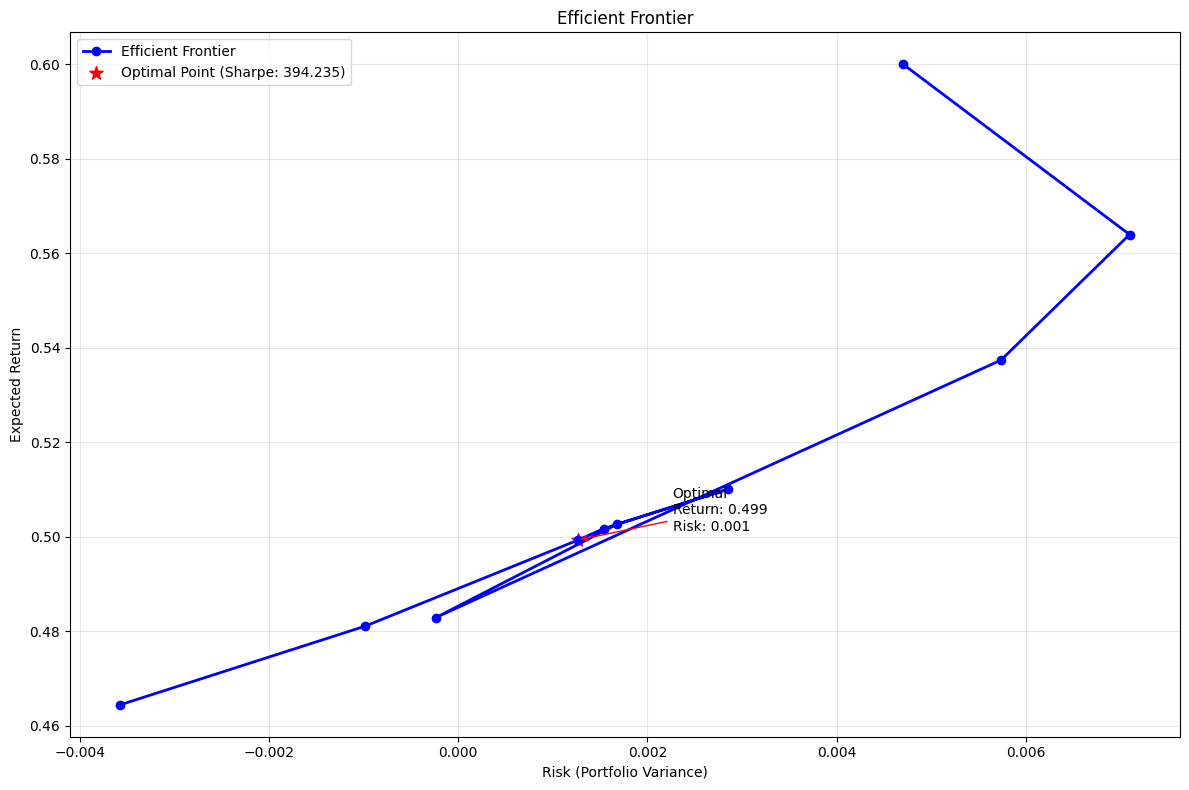

Optimal minimum return for maximum Sharpe ratio: 0.499299
Maximum Sharpe ratio: 394.235090


In [19]:
# Create a DataFrame for easier analysis
efficient_frontier = pd.DataFrame({
    'Return': returns,
    'Risk': risk
})

# Calculate Sharpe ratio (return/risk) for each point
efficient_frontier['Sharpe_Ratio'] = efficient_frontier['Return'] / efficient_frontier['Risk']

# Find the point with maximum Sharpe ratio
max_sharpe_idx = efficient_frontier['Sharpe_Ratio'].idxmax()
optimal_return = efficient_frontier.loc[max_sharpe_idx, 'Return']
optimal_risk = efficient_frontier.loc[max_sharpe_idx, 'Risk']

# Plot the efficient frontier
plt.figure(figsize=(12, 8))
plt.plot(efficient_frontier['Risk'], efficient_frontier['Return'], 'b-o', linewidth=2, markersize=6, label='Efficient Frontier')
plt.scatter(optimal_risk, optimal_return, color='red', s=100, marker='*', label=f'Optimal Point (Sharpe: {efficient_frontier.loc[max_sharpe_idx, "Sharpe_Ratio"]:.3f})')

plt.xlabel('Risk (Portfolio Variance)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate the optimal point
plt.annotate(f'Optimal\nReturn: {optimal_return:.3f}\nRisk: {optimal_risk:.3f}', 
             xy=(optimal_risk, optimal_return), 
             xytext=(optimal_risk + 0.001, optimal_return + 0.002),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

print(f"Optimal minimum return for maximum Sharpe ratio: {efficient_frontier.loc[max_sharpe_idx, 'Return']:.6f}")
print(f"Maximum Sharpe ratio: {efficient_frontier.loc[max_sharpe_idx, 'Sharpe_Ratio']:.6f}")


In [20]:
optimal_weights = optimize_portfolio(min_return=0.5)
print("Optimal Weights:", optimal_weights)

[outer 1] t=1.0e+01, f=35.9456
[outer 2] t=1.0e+02, f=3.55053
[outer 3] t=1.0e+03, f=0.324647
[outer 4] t=1.0e+04, f=0.00845215
[outer 5] t=1.0e+05, f=-0.0195879
[outer 6] t=1.0e+06, f=-0.0225933
[outer 7] t=1.0e+07, f=-0.0228989
[outer 8] t=1.0e+08, f=-0.0229295
[outer 1] t=1.0e+01, f=0.310915
[outer 2] t=1.0e+02, f=0.192007
[outer 3] t=1.0e+03, f=0.0550386
[outer 4] t=1.0e+04, f=0.00830511
[outer 5] t=1.0e+05, f=0.00830511
[outer 6] t=1.0e+06, f=0.0062167
[outer 7] t=1.0e+07, f=0.00589157
[outer 8] t=1.0e+08, f=0.00589157
Optimal Weights: [5.69803018e-02 4.73407255e-02 2.99031905e-05 1.90489665e-02
 7.49257417e-03 4.51505121e-03 4.24961782e-02 1.74964948e-02
 4.19253711e-02 3.00207916e-02 2.02715850e-02 2.75017895e-02
 1.06884081e-02 8.88885720e-04 5.33199587e-02 6.98347150e-03
 3.59130776e-02 1.05389314e-02 3.34146105e-03 1.39919955e-01
 7.89838624e-03 3.23008328e-02 1.02171021e-05 3.43157348e-02
 4.84842966e-03 2.09845071e-02 1.29144620e-01 5.23196701e-02
 6.06158256e-03 3.40870722

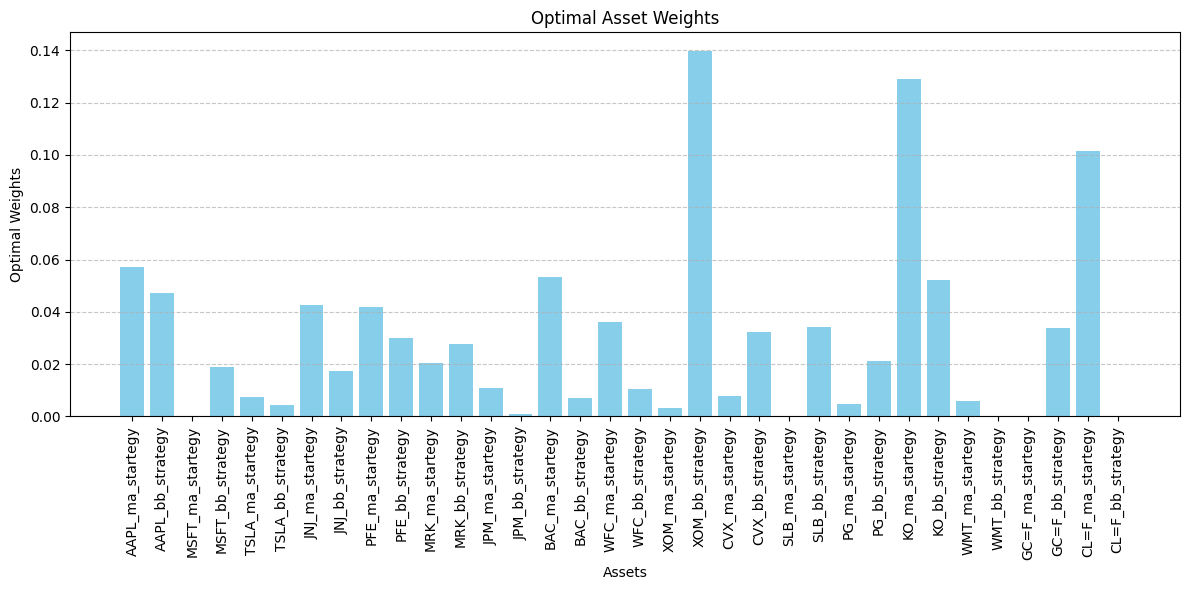

In [21]:
# Bar plot of optimal weights and their corresponding labels
labels = train_pnls.columns
plt.figure(figsize=(12, 6))
plt.bar(labels, optimal_weights, color='skyblue')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Asset Weights')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
def plot_cumulative_returns(pnls: pd.DataFrame, optimal_weights: np.ndarray, split: str):
    """
    Plot cumulative returns from a DataFrame of PnLs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing PnLs for each strategy.
    title : str
        Title for the plot.
    """
    # Introduce cumulative returns pd.DataFrame for all the strategies
    cumulative_returns = pd.DataFrame(index=pnls.index)
    for col in pnls.columns:
        cumulative_returns[col] = np.cumsum(pnls[col].fillna(0))
    
    # Plot all cumulative returns on single graph
    plt.figure(figsize=(14, 8))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    plt.title(f"Cumulative Returns of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the average cumulative return of all strategies graph
    average_cumulative_return = cumulative_returns.mean(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(average_cumulative_return.index, average_cumulative_return, label='Average Cumulative Return', color='blue')
    plt.title(f"Average Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Average Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the weighted cumulative return of all strategies graph using optimal weights
    weighted_cumulative_return = (cumulative_returns * optimal_weights).sum(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(weighted_cumulative_return.index, weighted_cumulative_return, label='Weighted Cumulative Return', color='green')
    plt.title(f"Weighted Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Weighted Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

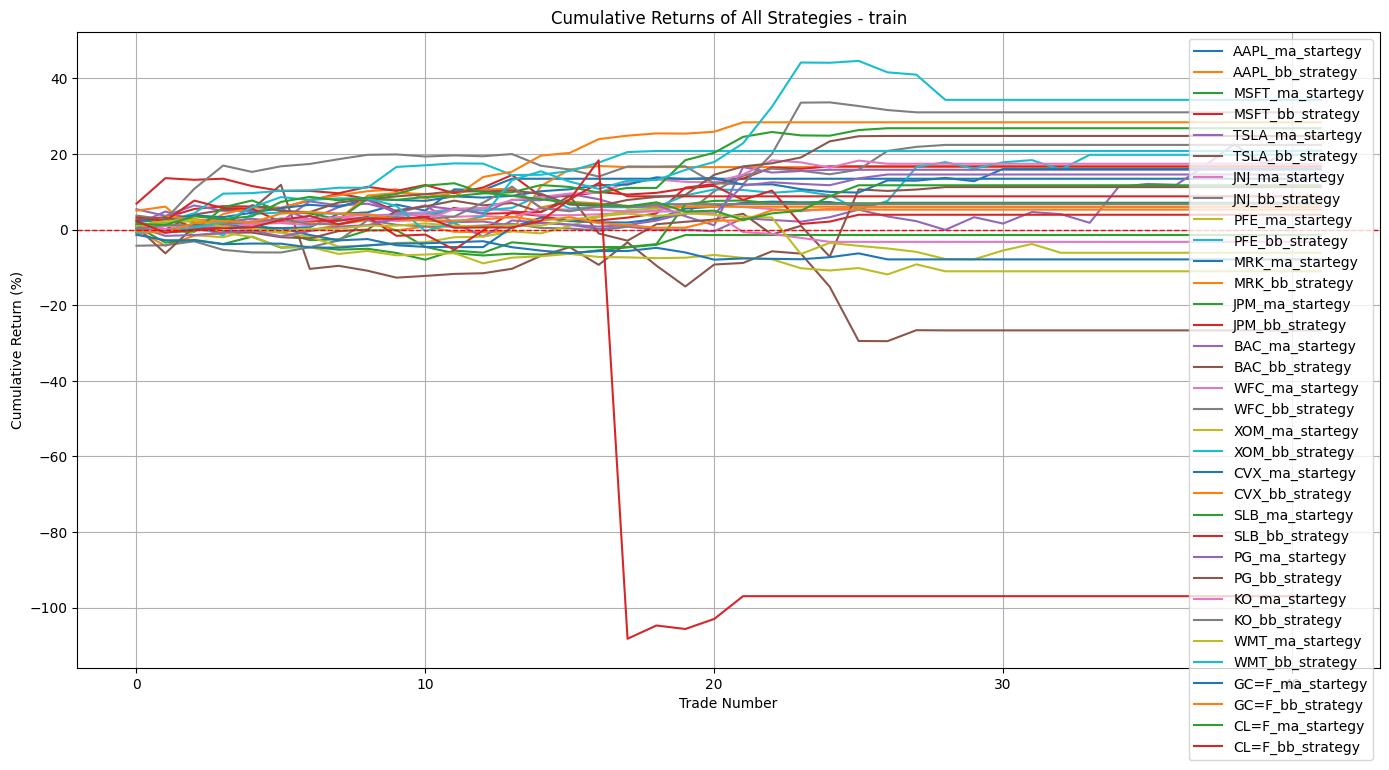

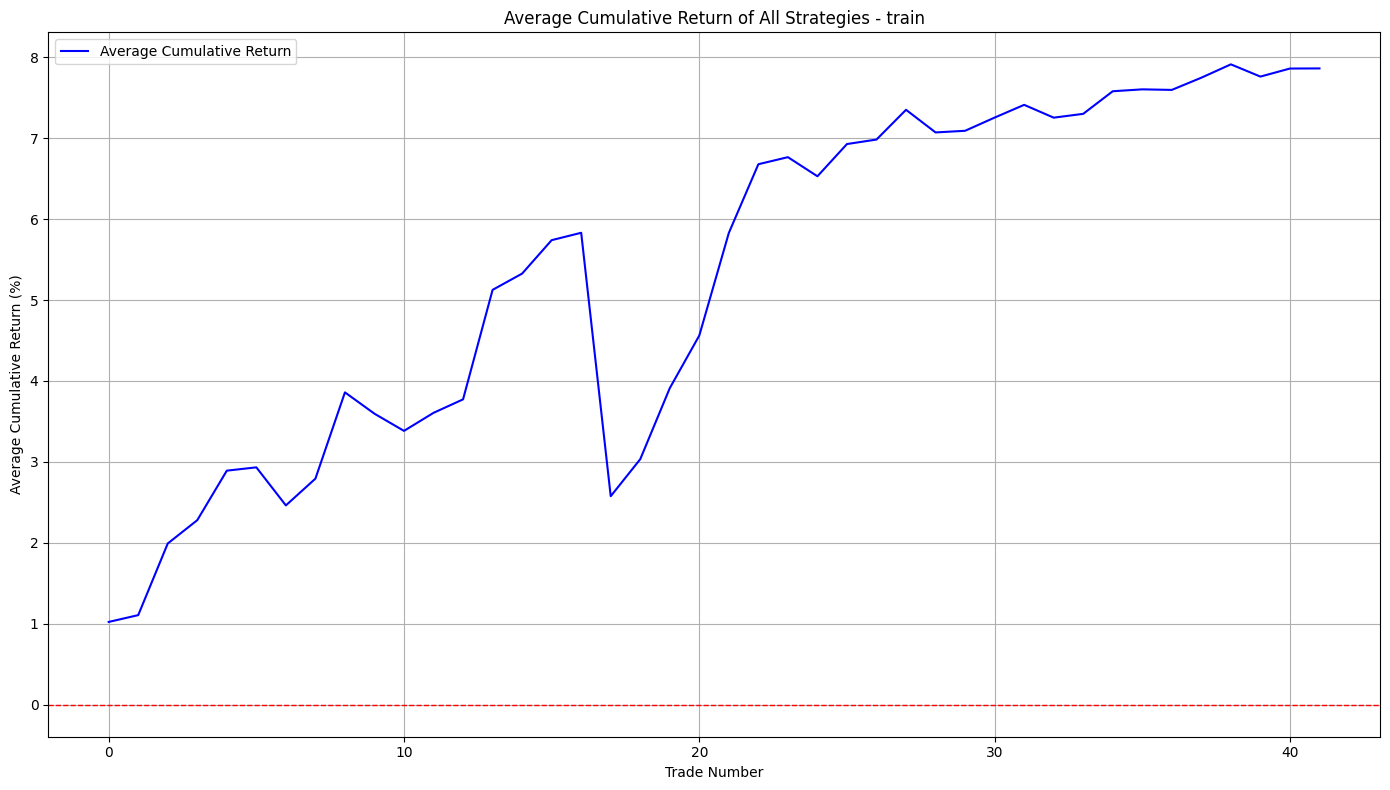

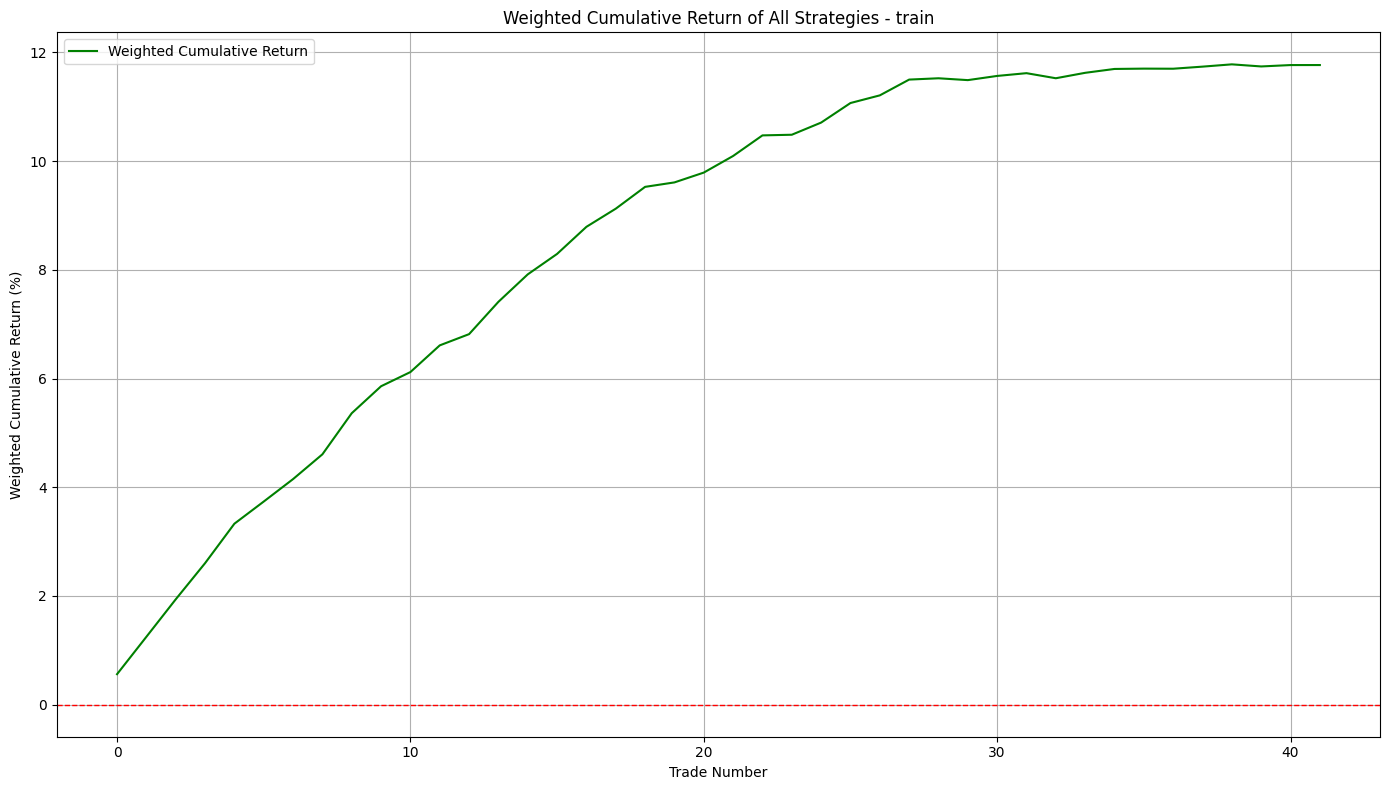

In [23]:
plot_cumulative_returns(train_pnls, optimal_weights, "train")

Processing strategies for tech sector...
AAPL MA Strategy PnLs: [-1.0429440050615637, -1.023662707970092, 0.9258771955005833, -1.9412629389481775]
AAPL BB Strategy PnLs: [-0.587815166049979, 5.5579121430999825]
MSFT MA Strategy PnLs: [-2.662254409729354, 0.12472923096903314, -0.40433943271040074, 0.46543639402474907, -0.603116598100666, -0.6027992716405993, -1.028886432418102]
MSFT BB Strategy PnLs: [0.5418055824903548, -1.8594271093002042]
TSLA MA Strategy PnLs: [-5.694553722096759, -0.10219306444721542, 1.7002881015874511, -0.52943520721977, -1.1387381846064173, 0.6263735117226884, 1.776579679334922, -5.269623506518388, -14.259893789082124]
TSLA BB Strategy PnLs: [4.5447010737882705, -4.224684123726454, -2.2632429444132987, 1.397832907829855]
Finished processing strategies for tech sector.

Processing strategies for healthcare sector...
JNJ MA Strategy PnLs: [-0.7762959902570122, -0.4469818985172988, -0.7431954179280313, -0.09601978569491118, 0.48862012895580326, -0.04746044110862336

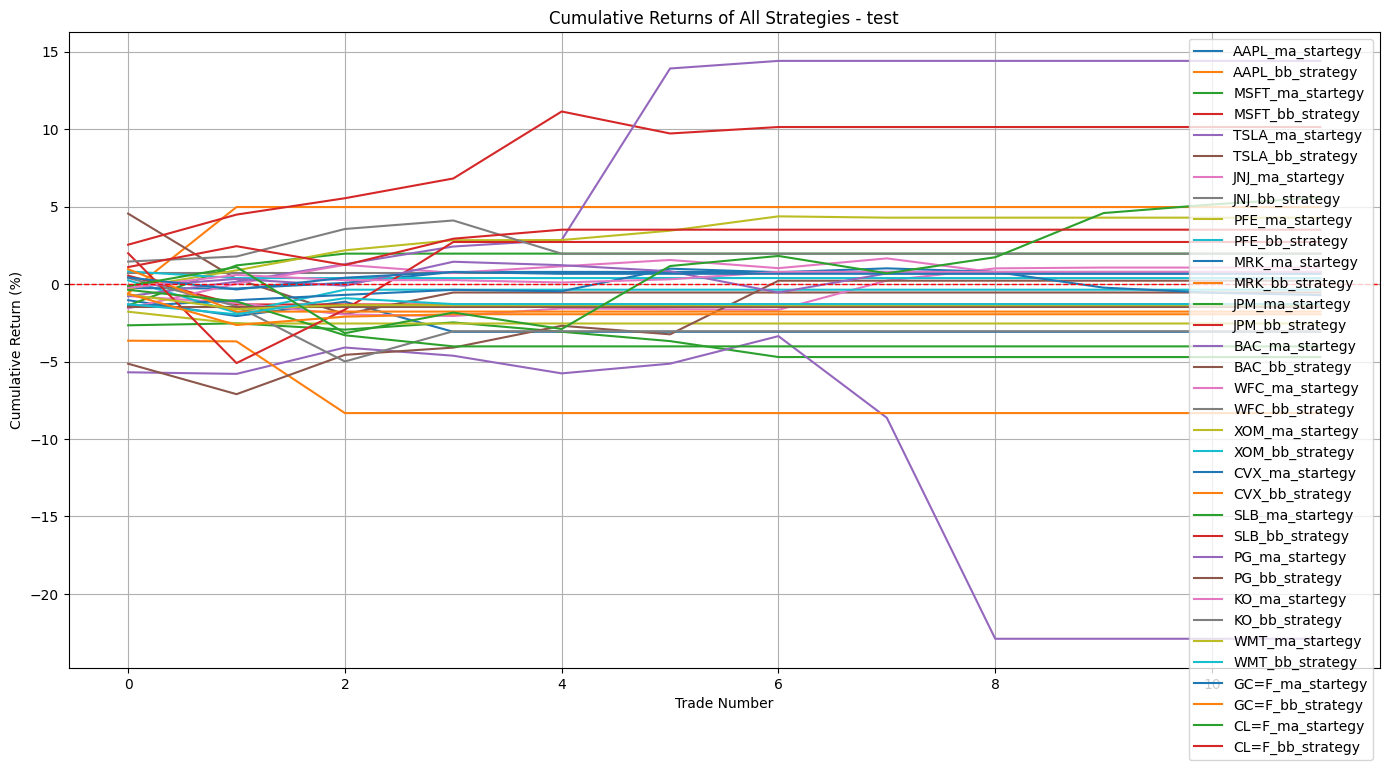

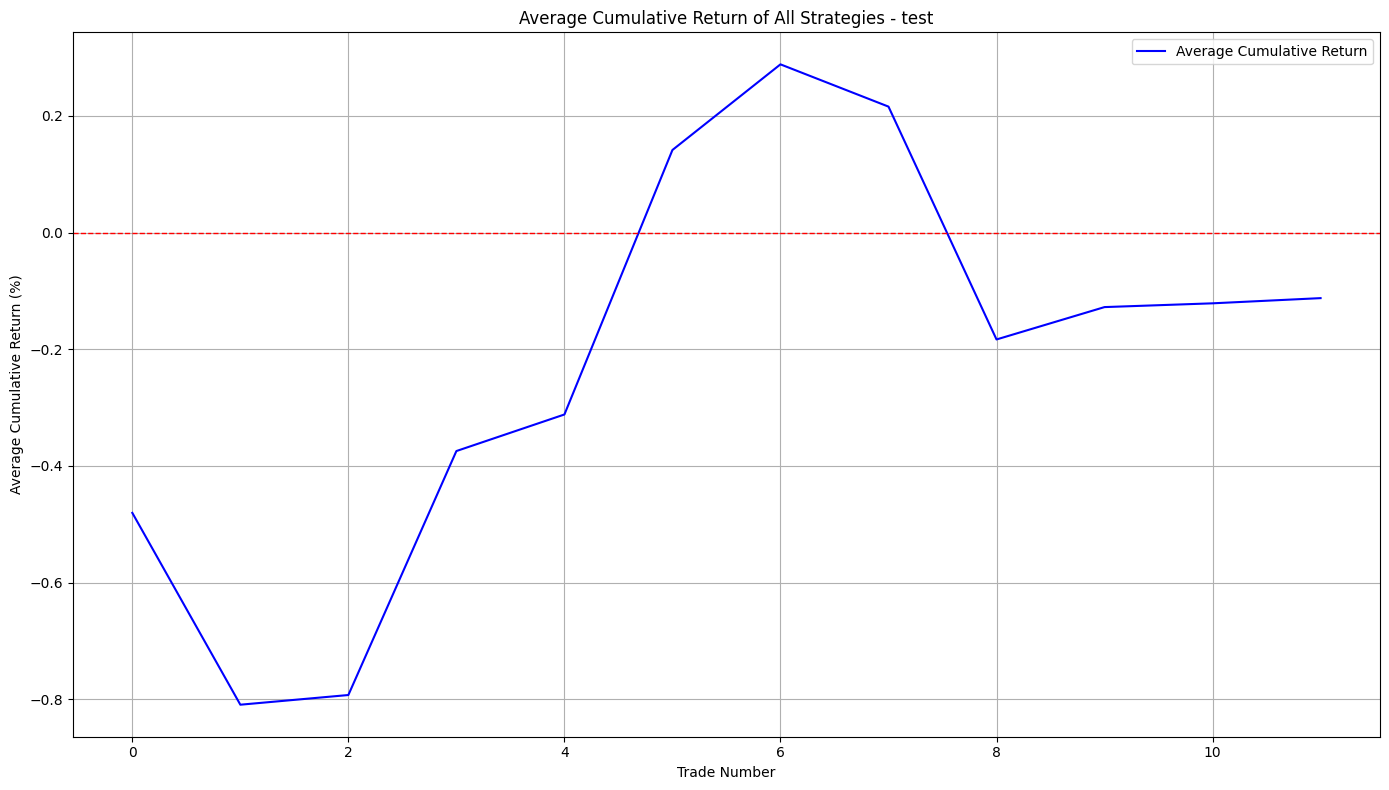

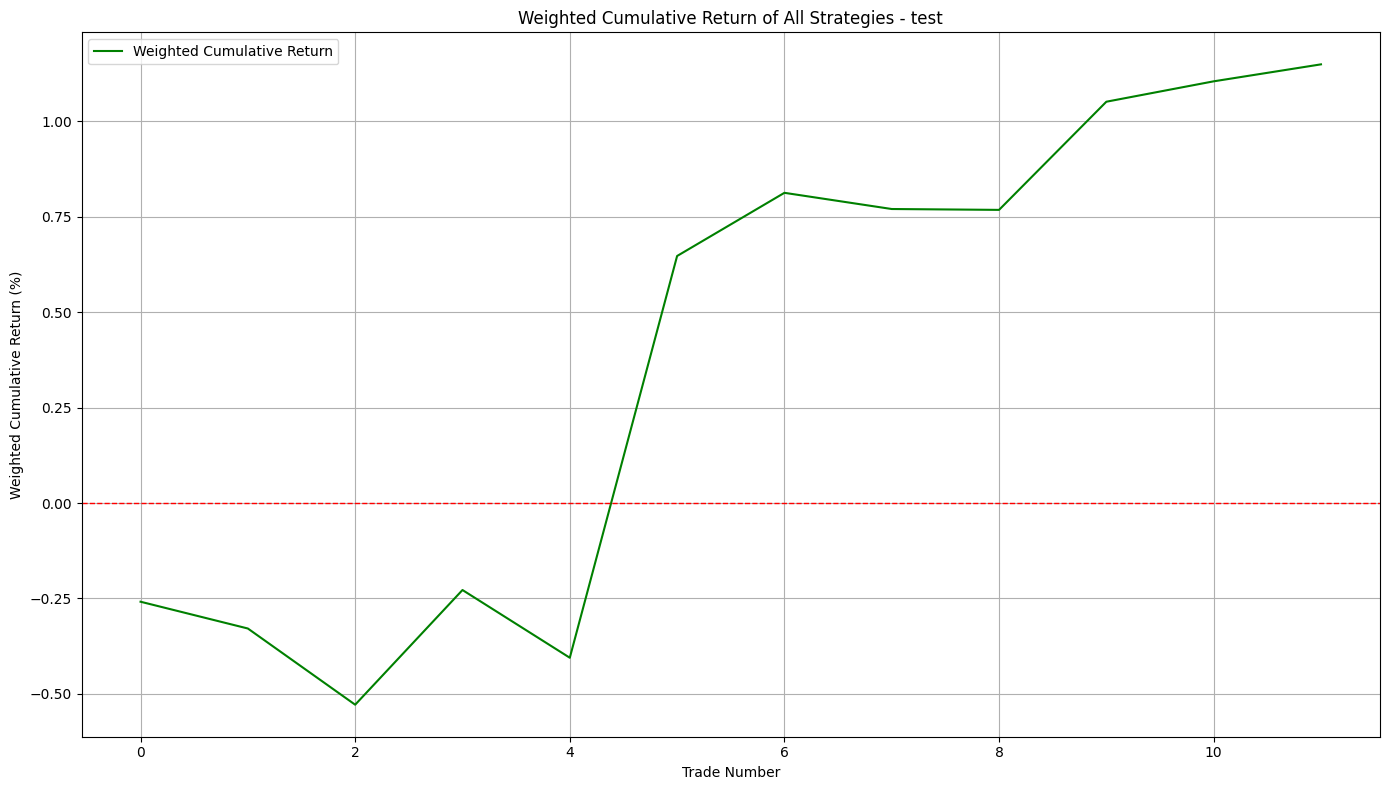

In [24]:
plot_cumulative_returns(generate_backtest_pnl("test"), optimal_weights, "test")